In [1]:
from src.time_series_prep import *
import pandas as pd
from models.shared_layer import *
from torchviz import make_dot
from torchsummary import summary
from src.data_preprocessing import *
from src.visualizations import *
from src.global_configs import *
from src.time_series_prep import *
import logging
from src.post_processing import *
from collections import defaultdict
from sklearn.metrics import r2_score
torch.set_printoptions(precision=10)  # Set precision to 10 decimal places

# Initialize logger
logging.basicConfig(
    filename='training.log',  # File where logs will be saved
    level=logging.INFO,  # Set logging level to INFO
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    # filemode='w'  # Overwrite log file on each run
)
logger = logging.getLogger()

In [2]:
scaler = process_all_csv_files(input_folder, output_folder_train, timestamp_col='ts', freq='5min', agg_func='mean')
# abs_patients_errors_PHs =  {key: [] for key in prediction_horizons}
# squared_patients_errors_PHs =  {key: [] for key in prediction_horizons}

In [3]:
def prepare_data_evaluation(scaler, model_type, prediction_horizon, model_all_train_read, test_loader):

    model_all_train_read.load_state_dict(torch.load(f'saved_models//model_{model_type}_attention_{str(prediction_horizon)}_{0}.pth',weights_only=False))
    model_all_train_read.to(device)
    model_all_train_read.eval();              
    outputs_all_batches, targets_all_batches = model_prediction(model_all_train_read,test_loader, device, model_type)

    predictions_tensor = torch.cat(outputs_all_batches, dim=0).cpu()
    ground_truth_tensor = torch.cat(targets_all_batches, dim=0).cpu()

    # Mask zero values
    predictions_mask = (predictions_tensor != 0)
    ground_truth_mask = (ground_truth_tensor != 0)

    # Initialize transformed tensors with zeros (to preserve zeros)
    predictions_transformed = torch.zeros_like(predictions_tensor)
    ground_truth_transformed = torch.zeros_like(ground_truth_tensor)

    # Apply the scaler.inverse_transform only to non-zero values and convert back to torch tensor
    if predictions_mask.any():
        non_zero_predictions = predictions_tensor[predictions_mask].unsqueeze(-1).numpy()
        inverse_transformed_predictions = scaler.inverse_transform(non_zero_predictions).squeeze()
        predictions_transformed[predictions_mask] = torch.exp(torch.tensor(
            inverse_transformed_predictions, dtype=predictions_tensor.dtype
        ))

    if ground_truth_mask.any():
        non_zero_ground_truth = ground_truth_tensor[ground_truth_mask].unsqueeze(-1).numpy()
        inverse_transformed_ground_truth = scaler.inverse_transform(non_zero_ground_truth).squeeze()
        ground_truth_transformed[ground_truth_mask] = torch.exp(torch.tensor(
            inverse_transformed_ground_truth, dtype=ground_truth_tensor.dtype
        ))

    ground_truth_flat = ground_truth_transformed
    predictions_flat= predictions_transformed
    return predictions_flat, ground_truth_flat                                             

In [4]:
def r2_score_each_patient(predictions_flat, ground_truth_flat):
    r2_scores = []
    for patient_idx in range(np.array(predictions_flat).shape[1]):  # Iterate over columns (patients)
        pred = predictions_flat[:, patient_idx]  # Get predictions for this patient
        true = ground_truth_flat[:, patient_idx]  # Get ground truth for this patient
        non_zero_mask = true != 0
        pred = pred[non_zero_mask]
        true = true[non_zero_mask]
        r2 = r2_score(true, pred)
        r2_scores.append(r2)
    return r2_scores

In [5]:
def MADP_each_patient(predictions_flat, ground_truth_flat):
    madp_scores = []
    for patient_idx in range(predictions_flat.shape[1]):  # Iterate over columns (patients)
        pred = predictions_flat[:, patient_idx]  # Get predictions for this patient
        true = ground_truth_flat[:, patient_idx]  # Get ground truth for this patient
        
        # Avoid division by zero by excluding cases where true value is zero
        non_zero_mask = true != 0
        pred = pred[non_zero_mask]
        true = true[non_zero_mask]
        
        madp = (abs((true - pred) / true)).mean() * 100  # Calculate MADP
        madp_scores.append(madp)
    # Step 3: Print MADP scores for each patient
    return madp_scores
    

In [6]:

# Apply style
# plt.style.use("tableau-colorblind10")
plt.style.use("default")

# Set Times New Roman font and darker border
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 21     # Axis label font size
plt.rcParams['xtick.labelsize'] = 21      # X-tick font size
plt.rcParams['ytick.labelsize'] = 21      # Y-tick font size
plt.rcParams['legend.fontsize'] = 21      # Y-tick font size

In [7]:
import matplotlib.pyplot as plt
def calculate_zone_percentages(zones):
    total_points = sum(zones)
    if total_points == 0:
        return [0] * len(zones)  # Avoid division by zero if there are no points
    return [(count / total_points) * 100 for count in zones]

#This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
#of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
def clarke_error_grid(ref_values, pred_values, title_string, mask_value):
    if mask_value is not None:
        filtered_data = [(ref, pred) for ref, pred in zip(ref_values, pred_values) if ref != mask_value and pred != mask_value]

        ref_values, pred_values = zip(*filtered_data) if filtered_data else ([], [])
    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    # if max(ref_values) > 400 or max(pred_values) > 400:
    #     print "Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values))
    # if min(ref_values) < 0 or min(pred_values) < 0:
    #     print "Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values))

    #Clear plot
    plt.clf()
    plt.figure(dpi=600)
    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=3)
    # plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)
    plt.xticks(rotation=45)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B
    plt.show()
    print(calculate_zone_percentages(zone))
    print(zone)
    return plt, zone, calculate_zone_percentages(zone)

In [8]:
idx = 0
for prediction_horizon in prediction_horizons:
    idx +=1
    print(f"prediction horizon: {prediction_horizon}")    
    model_type = 'shared-layer'
    train_loader, validation_loader, all_train_loader, test_loader, input_shape, input_shape_test, output_shape, output_shape_test =  prepare_data_loader(
                                                                                        window_size,BATCH_SIZE, prediction_horizon,
                                                                                        model_type, split_ratio = 0.7, df = None, df_test = None,
                                                                                        output_folder_train=output_folder_train, shuffle = False)
    model_all_train_read =  SharedLayerModelWithAttention(input_shape =input_shape , output_shape=output_shape)
    predictions_flat_shared_layer, ground_truth_flat_shared_layer = prepare_data_evaluation(scaler, model_type, prediction_horizon, model_all_train_read, test_loader)
    r2_multitasking=r2_score_each_patient(predictions_flat_shared_layer, ground_truth_flat_shared_layer)
    print(f"R2 Score: {np.mean(r2_multitasking)}")    

    MADP_multitasking = MADP_each_patient(predictions_flat_shared_layer, ground_truth_flat_shared_layer)
    madps = []
    for idx, madp in enumerate(MADP_multitasking):
        madps.append(madp)
        # print(f"MADP: {madp:.2f}%")
    print(f"Mean MADP:{np.mean(madps)}")

    

prediction horizon: 3
R2 Score: 0.9523296970990778
Mean MADP:4.890642166137695
prediction horizon: 6
R2 Score: 0.8595304372034803
Mean MADP:9.010224342346191
prediction horizon: 9
R2 Score: 0.7396819550685302
Mean MADP:12.753654479980469
prediction horizon: 12
R2 Score: 0.6110135584311022
Mean MADP:15.987102508544922
prediction horizon: 15
R2 Score: 0.48527836964905663
Mean MADP:18.825252532958984
prediction horizon: 18
R2 Score: 0.3654565806115888
Mean MADP:21.307130813598633
prediction horizon: 24
R2 Score: 0.17254452441763146
Mean MADP:24.975013732910156


prediction horizon: 3
R2 Score: [0.9684751605366406, 0.9278709437674735, 0.9722049952734056, 0.9396403343326812, 0.9511118577530175, 0.931344773242801, 0.9682685733530297, 0.964529719073003, 0.9631457072261652, 0.9394922144197295, 0.9499930144676815, 0.9518790717433043]
MADP: 4.05%
MADP: 5.85%
MADP: 3.12%
MADP: 4.68%
MADP: 5.44%
MADP: 6.15%
MADP: 4.63%
MADP: 4.47%
MADP: 4.49%
MADP: 5.02%
MADP: 5.70%
MADP: 5.10%


<Figure size 640x480 with 0 Axes>

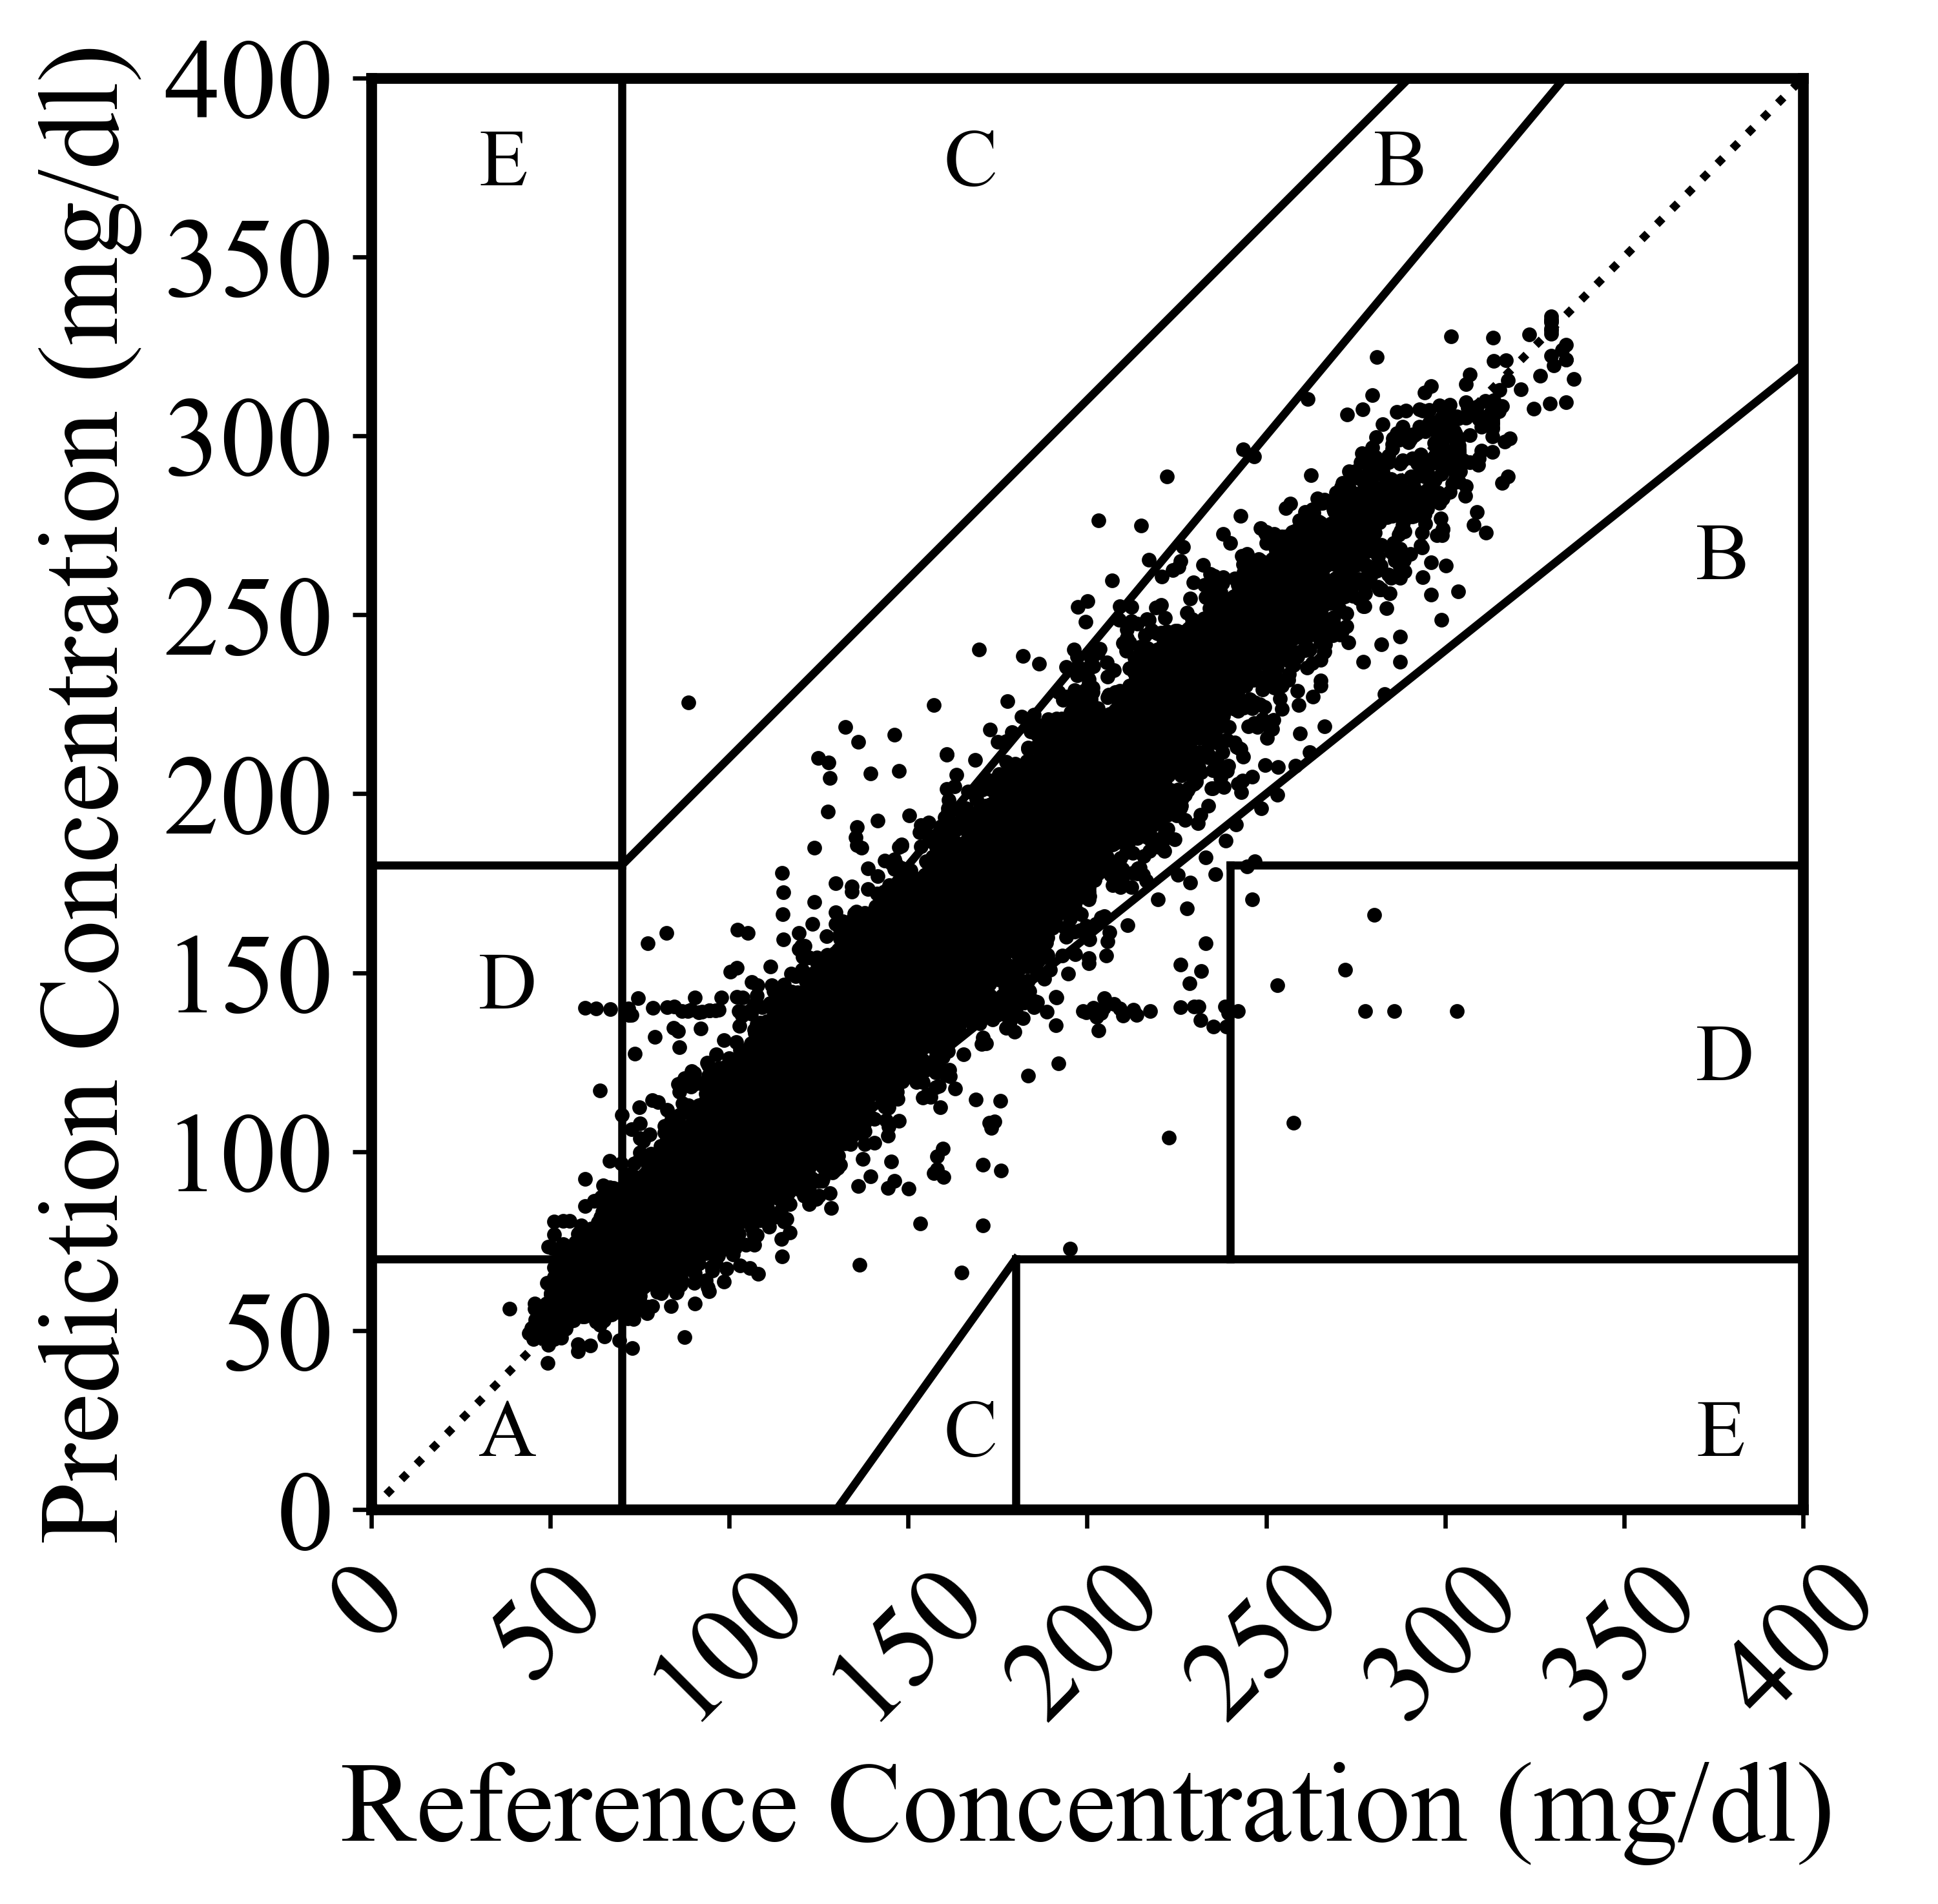

[97.61508083425892, 2.113414784647661, 0.0030852770578797977, 0.2684191040355424, 0.0]
[31639, 685, 1, 87, 0]
prediction horizon: 6
R2 Score: [0.9052676493265647, 0.8325252140904036, 0.9180502188847743, 0.8470163131560583, 0.8282279702485816, 0.811296222467086, 0.874703739073241, 0.879338271057478, 0.8708817487664965, 0.8191915741983191, 0.8542529400942458, 0.8736133850785143]
MADP: 7.46%
MADP: 10.01%
MADP: 6.03%
MADP: 8.61%
MADP: 10.33%
MADP: 11.01%
MADP: 9.52%
MADP: 8.24%
MADP: 8.75%
MADP: 9.56%
MADP: 9.70%
MADP: 8.90%


<Figure size 640x480 with 0 Axes>

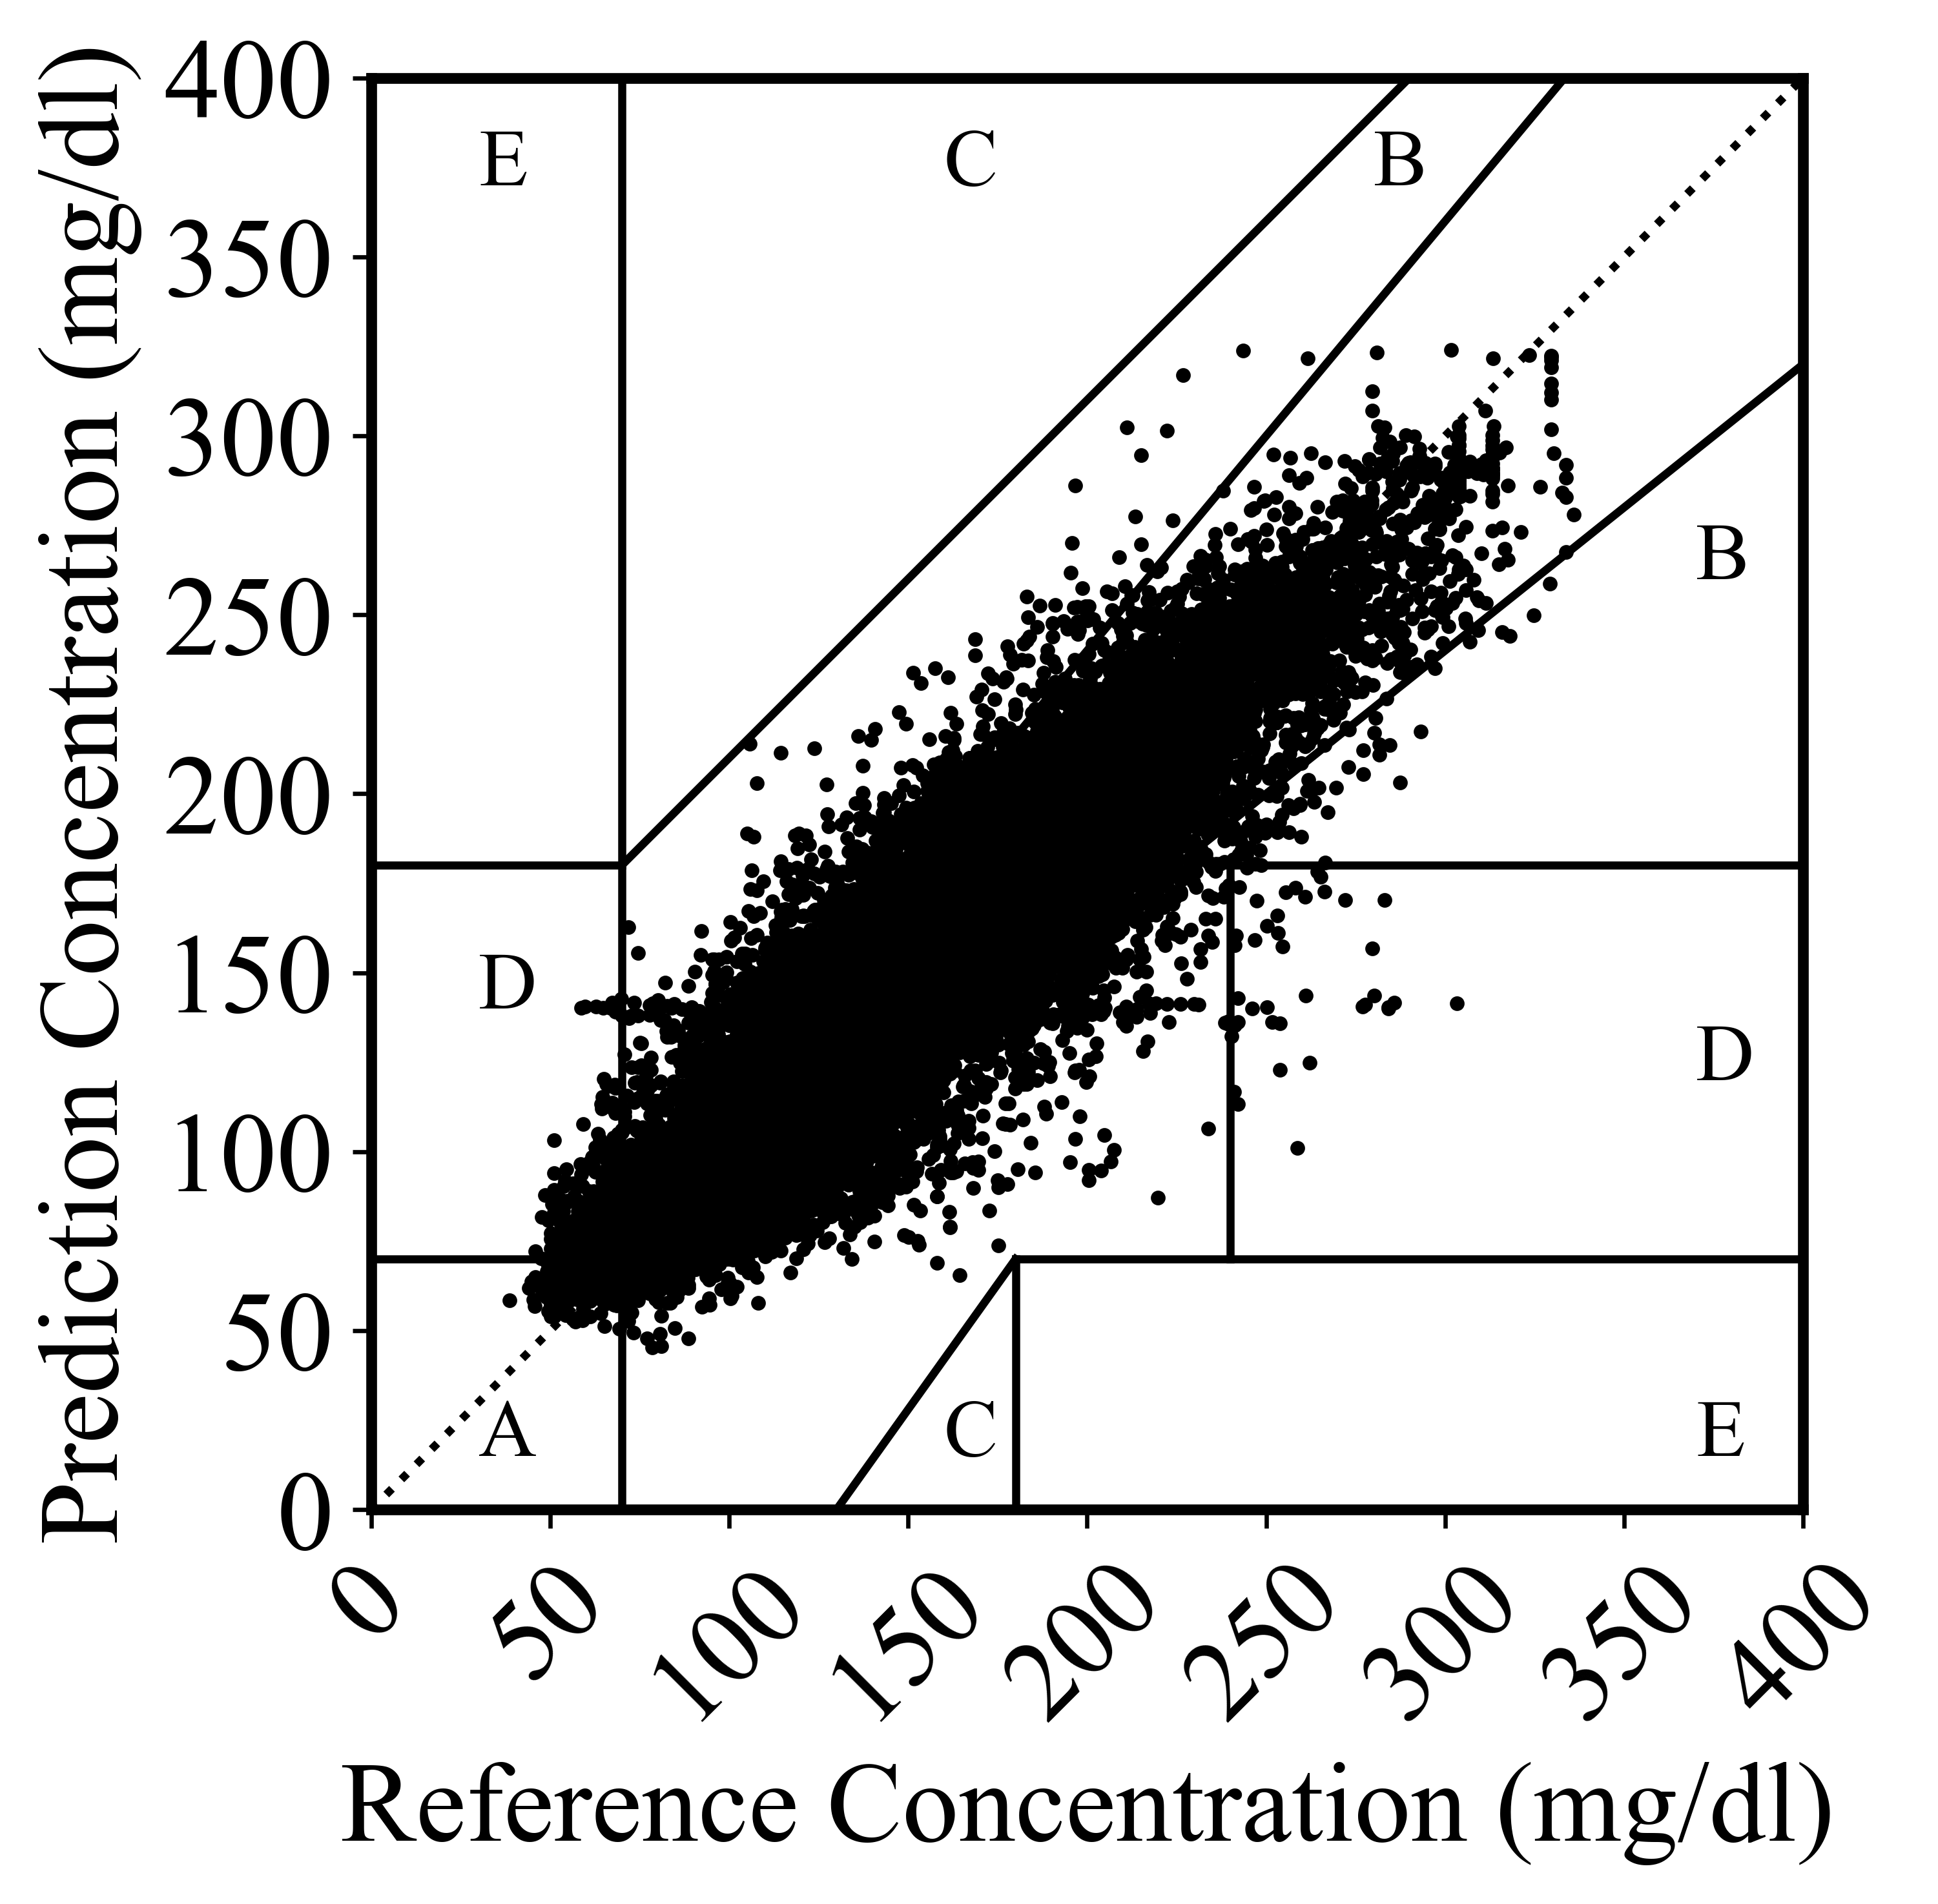

[89.64047442550037, 9.19508277736595, 0.0, 1.1644427971336793, 0.0]
[29022, 2977, 0, 377, 0]
prediction horizon: 9
R2 Score: [0.8175139050477528, 0.7018546391924831, 0.8541869225360993, 0.7403496380917255, 0.6753012510048058, 0.6863093605808867, 0.7413527006486116, 0.7698635109209887, 0.7484840133091939, 0.6544582653097271, 0.7189461268788153, 0.7675631273012724]
MADP: 10.73%
MADP: 14.07%
MADP: 8.61%
MADP: 12.00%
MADP: 14.64%
MADP: 14.84%
MADP: 13.95%
MADP: 11.28%
MADP: 12.59%
MADP: 14.00%
MADP: 13.88%
MADP: 12.46%


<Figure size 640x480 with 0 Axes>

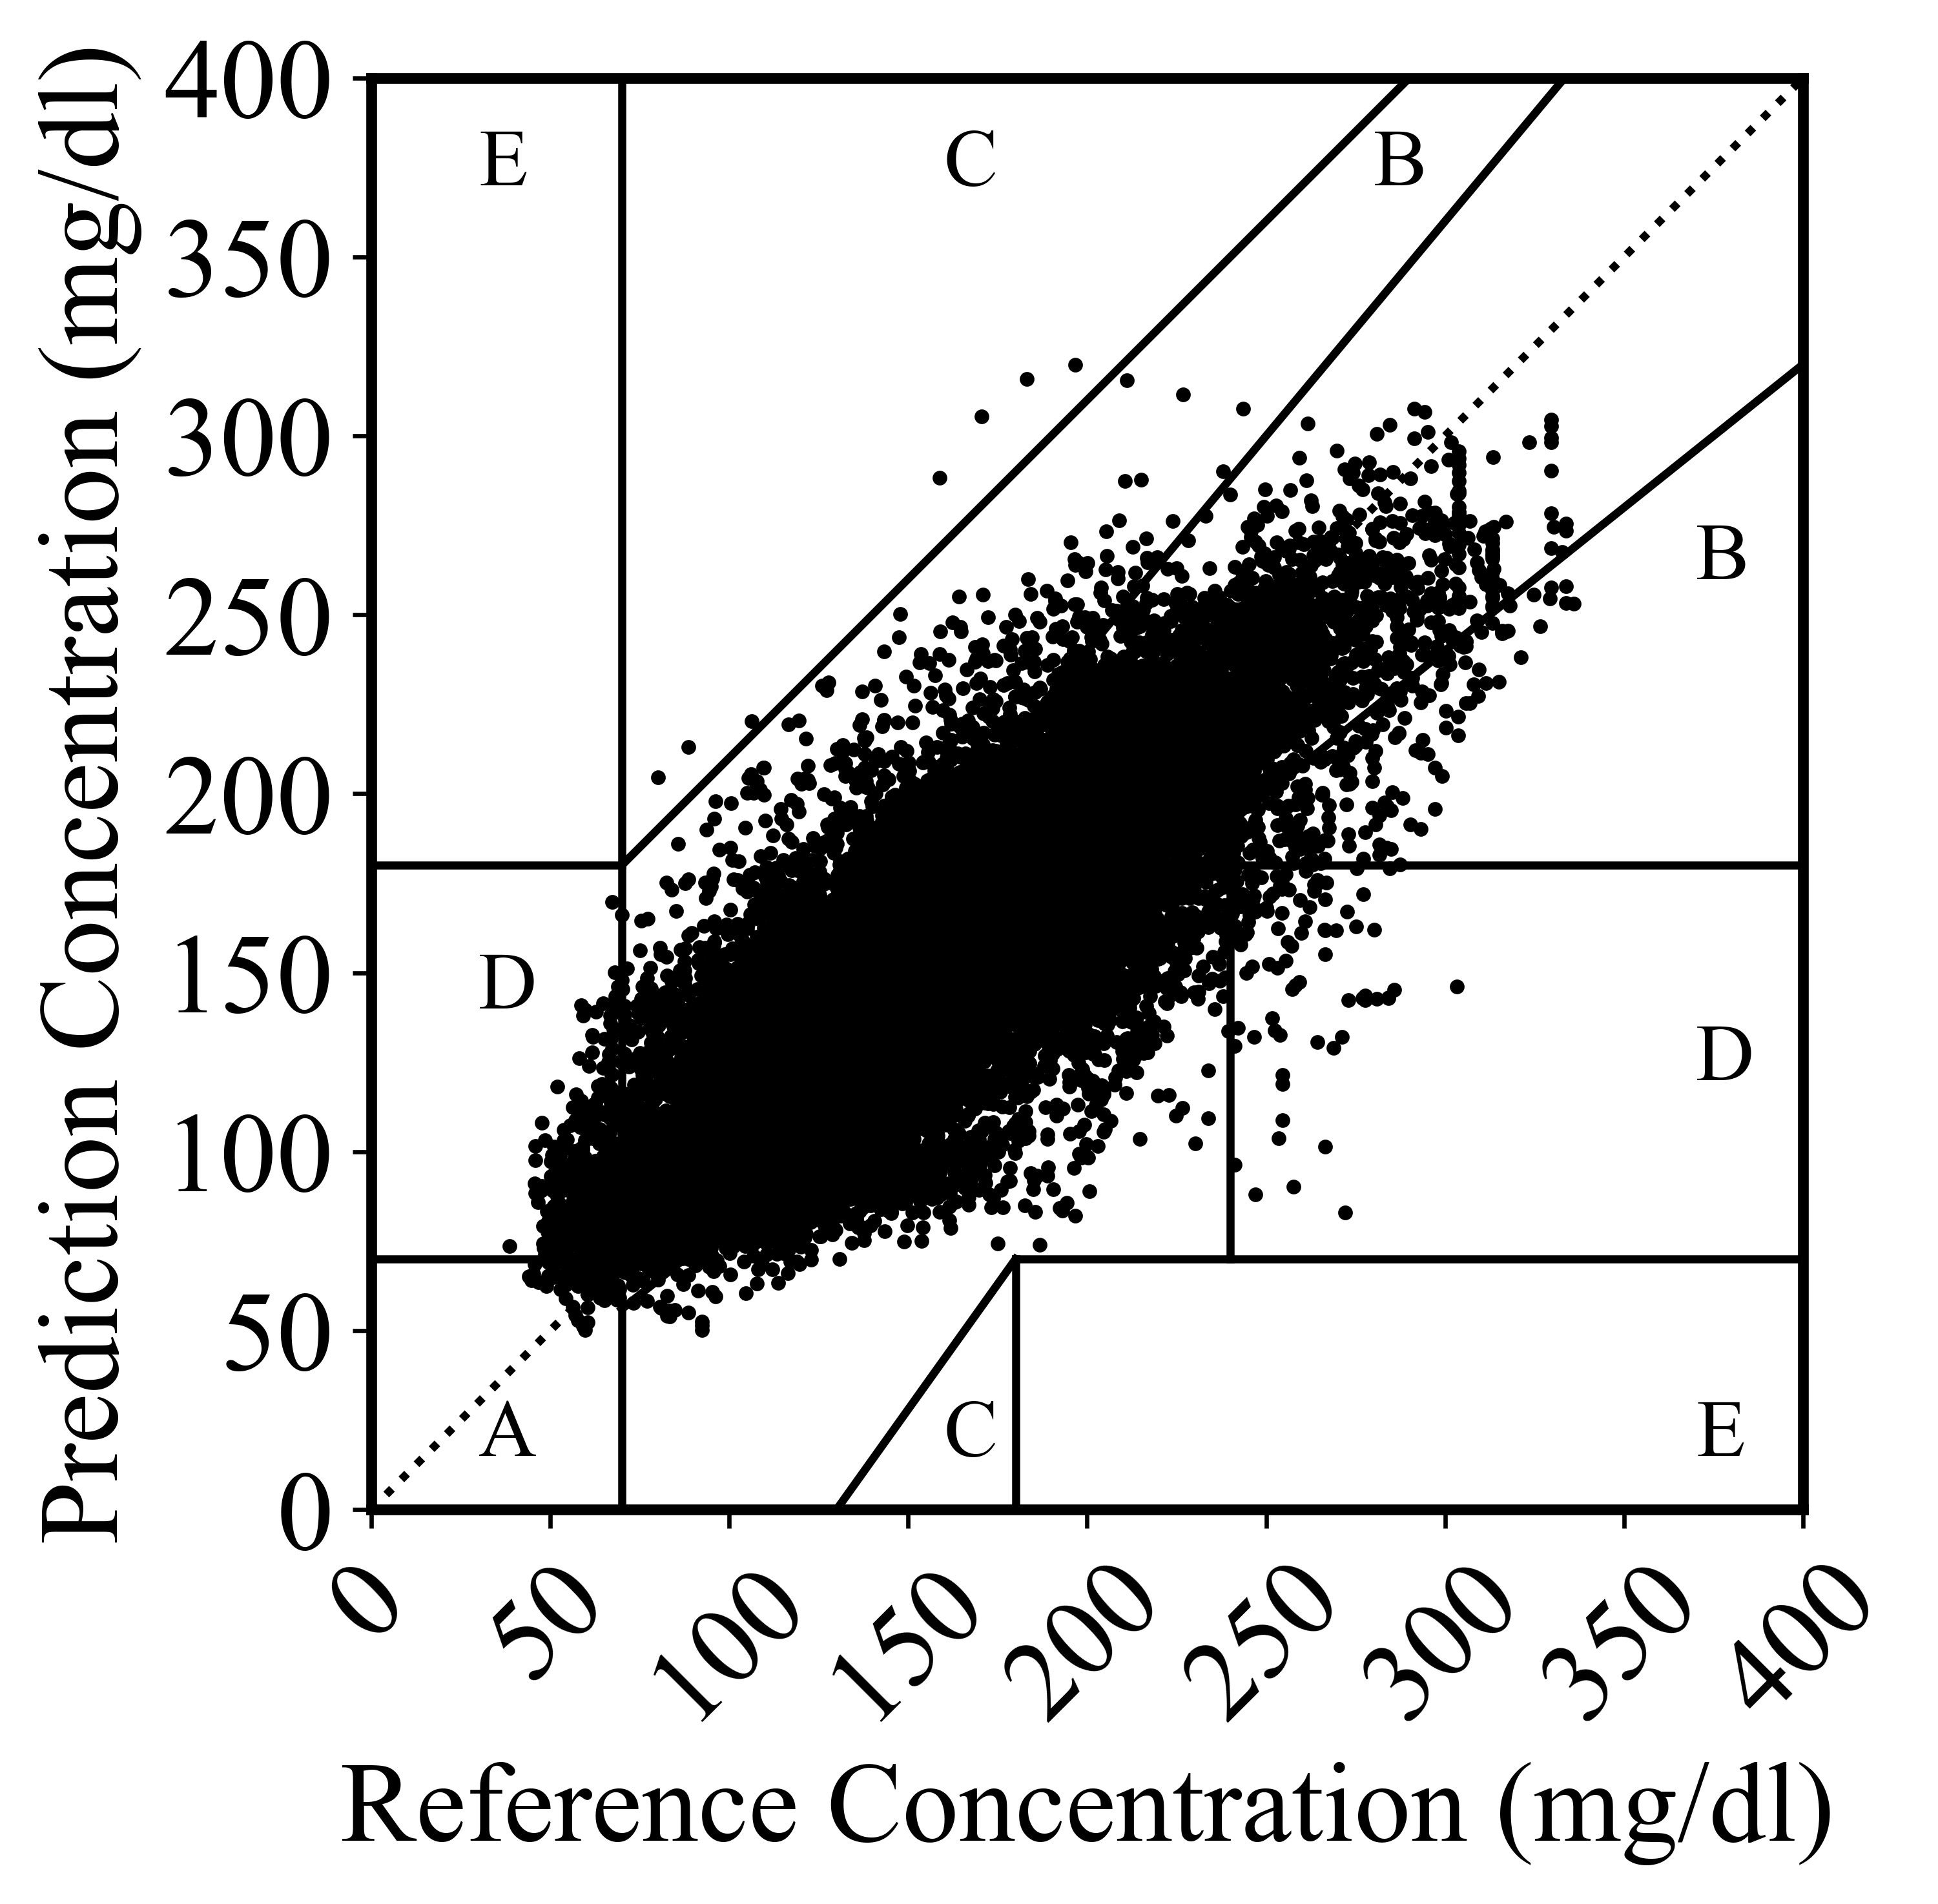

[80.09894867037724, 17.473716759431046, 0.021645021645021644, 2.4056895485466914, 0.0]
[25904, 5651, 7, 778, 0]
prediction horizon: 12
R2 Score: [0.7252270677321666, 0.5204770700434751, 0.7839842260430048, 0.6353026161205286, 0.5127209358864109, 0.5713982311852068, 0.5879523503370541, 0.6627110796906466, 0.6143259112733315, 0.48970002937008694, 0.5683499913430248, 0.6600131921482895]
MADP: 13.76%
MADP: 18.00%
MADP: 10.92%
MADP: 15.02%
MADP: 18.13%
MADP: 18.07%
MADP: 18.06%
MADP: 13.79%
MADP: 15.97%
MADP: 17.21%
MADP: 17.44%
MADP: 15.50%


<Figure size 640x480 with 0 Axes>

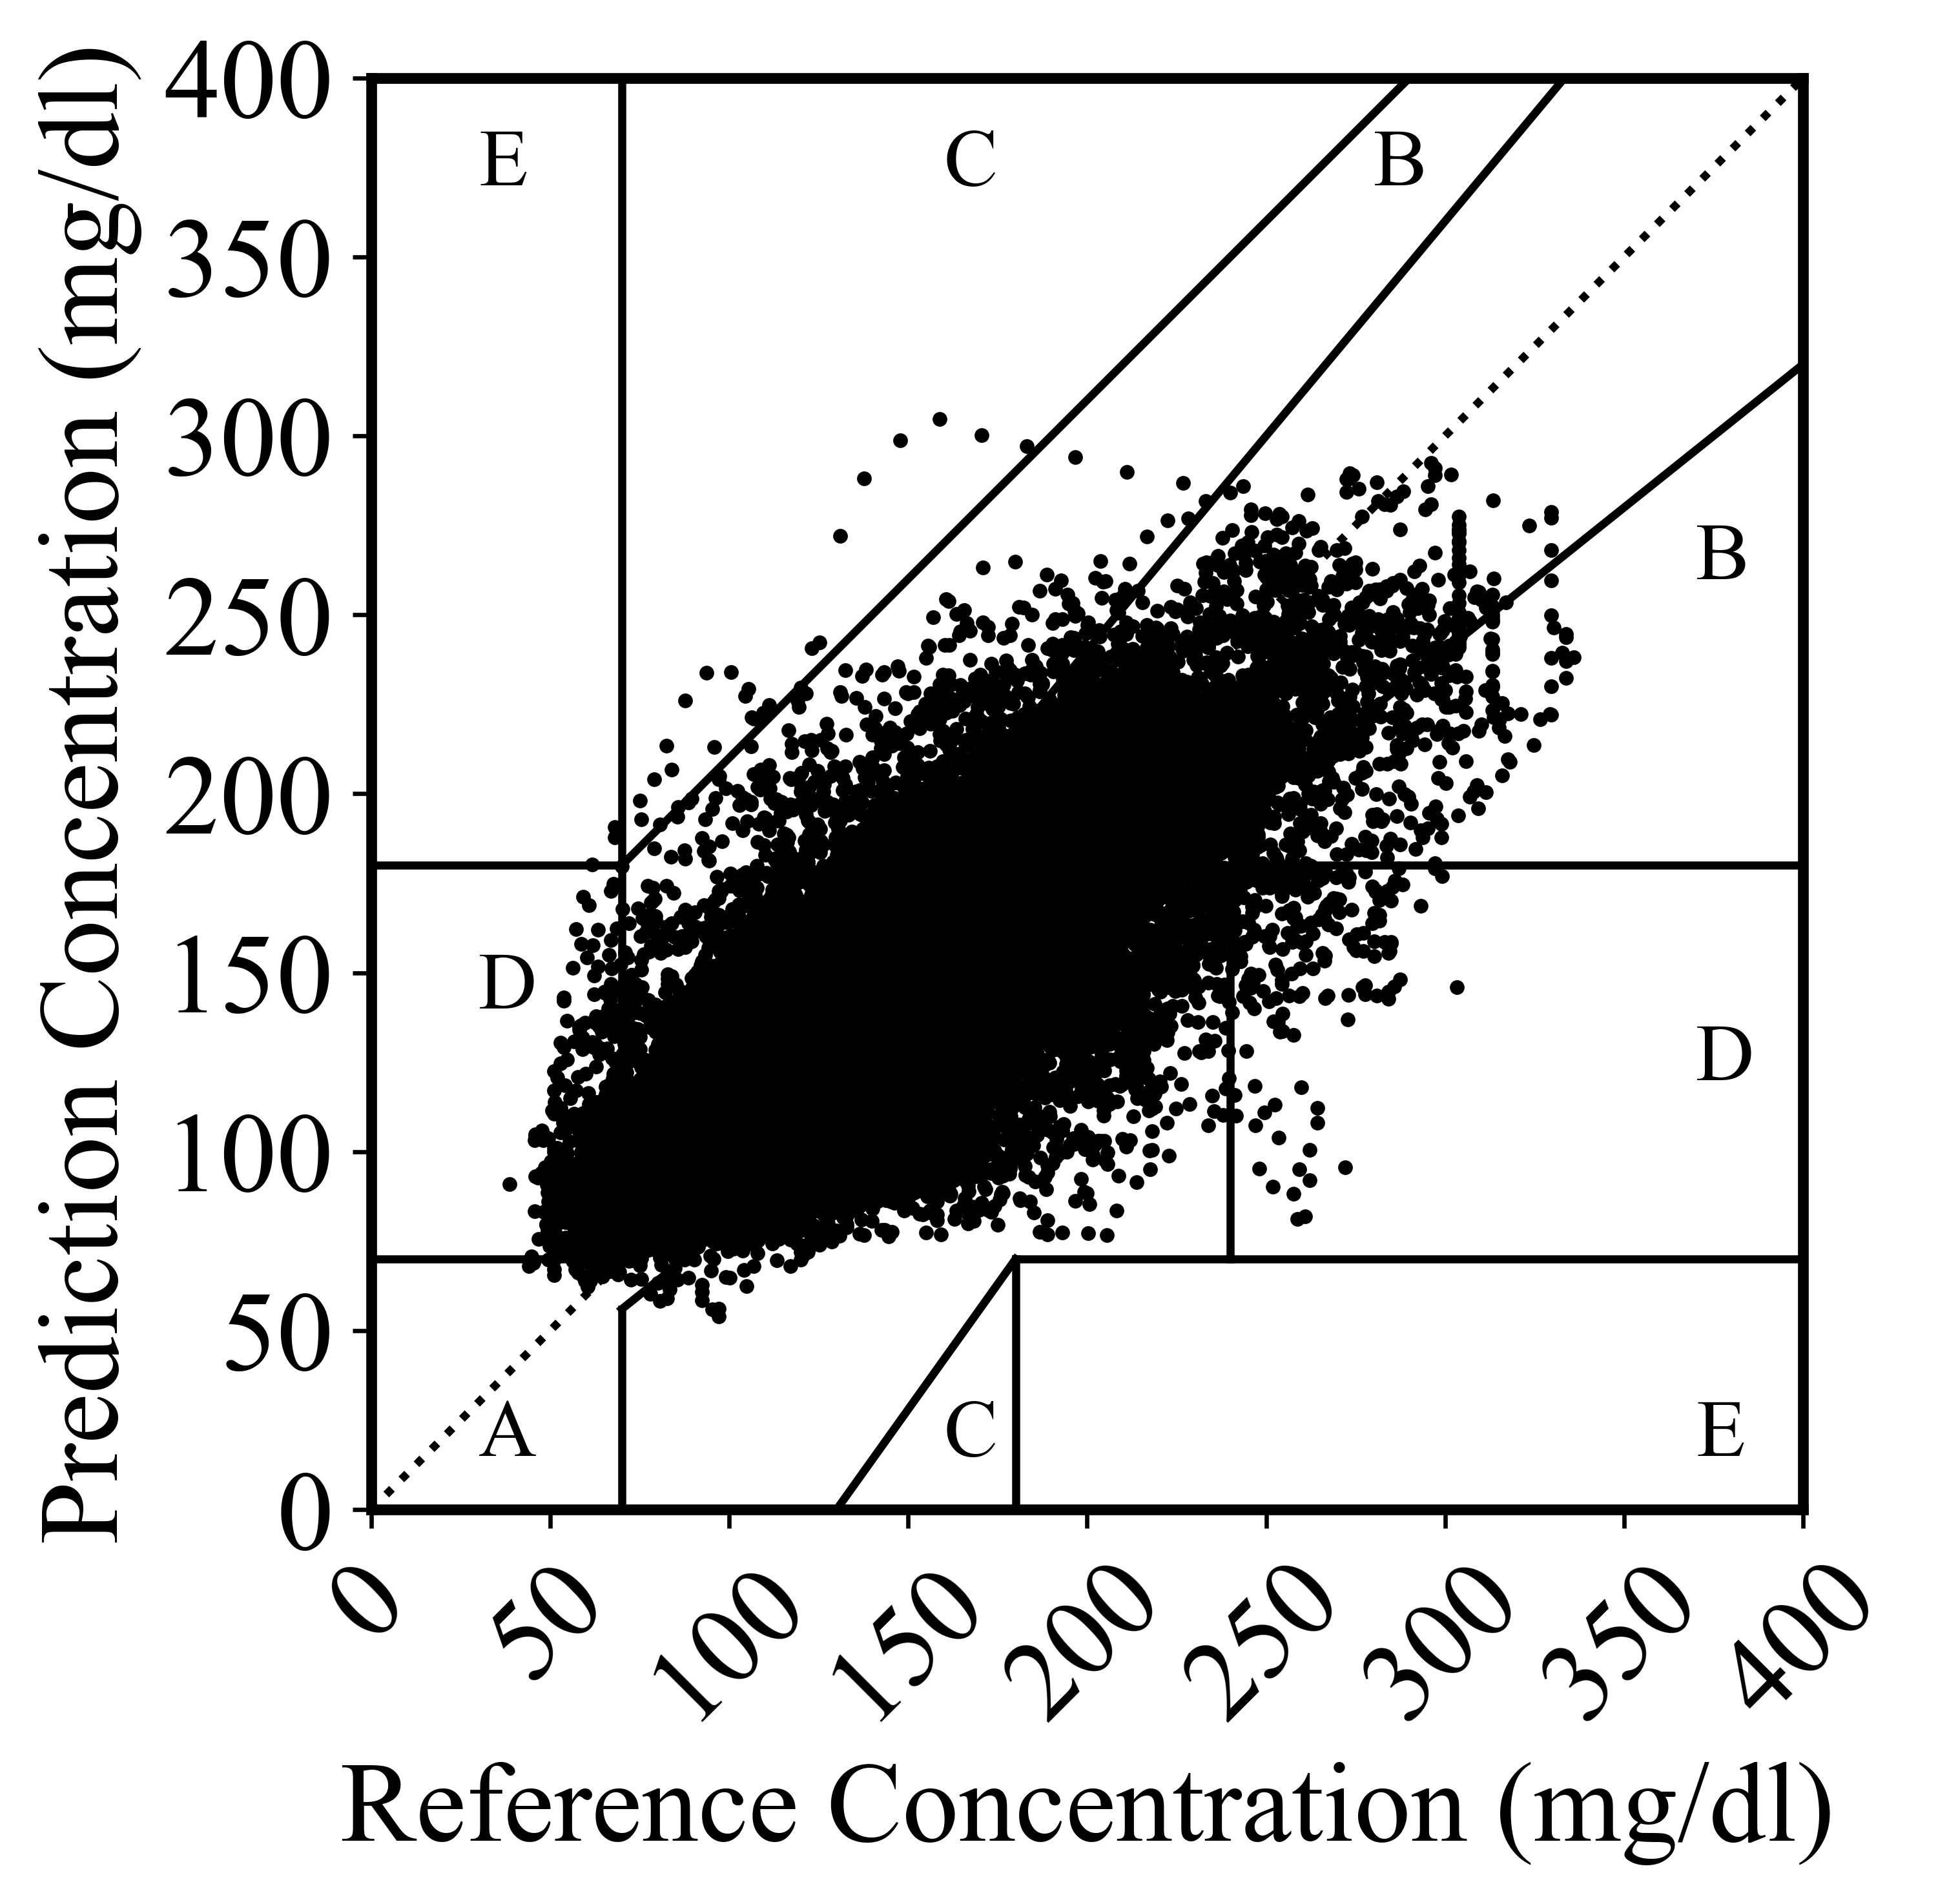

[71.87654779593858, 24.925705794947994, 0.07738979692917286, 3.111069836552749, 0.009286775631500743]
[23219, 8052, 25, 1005, 3]
prediction horizon: 15
R2 Score: [0.6236255101462358, 0.3387390527165042, 0.6959083685988614, 0.5222684971128259, 0.34793872871387566, 0.4612235926840267, 0.4437436160597562, 0.5626694748544994, 0.5377056949319474, 0.33112522902464714, 0.4262434000550924, 0.5321492708904071]
MADP: 16.74%
MADP: 21.51%
MADP: 13.24%
MADP: 18.11%
MADP: 21.15%
MADP: 20.73%
MADP: 21.21%
MADP: 16.03%
MADP: 17.76%
MADP: 20.56%
MADP: 20.18%
MADP: 18.68%


<Figure size 640x480 with 0 Axes>

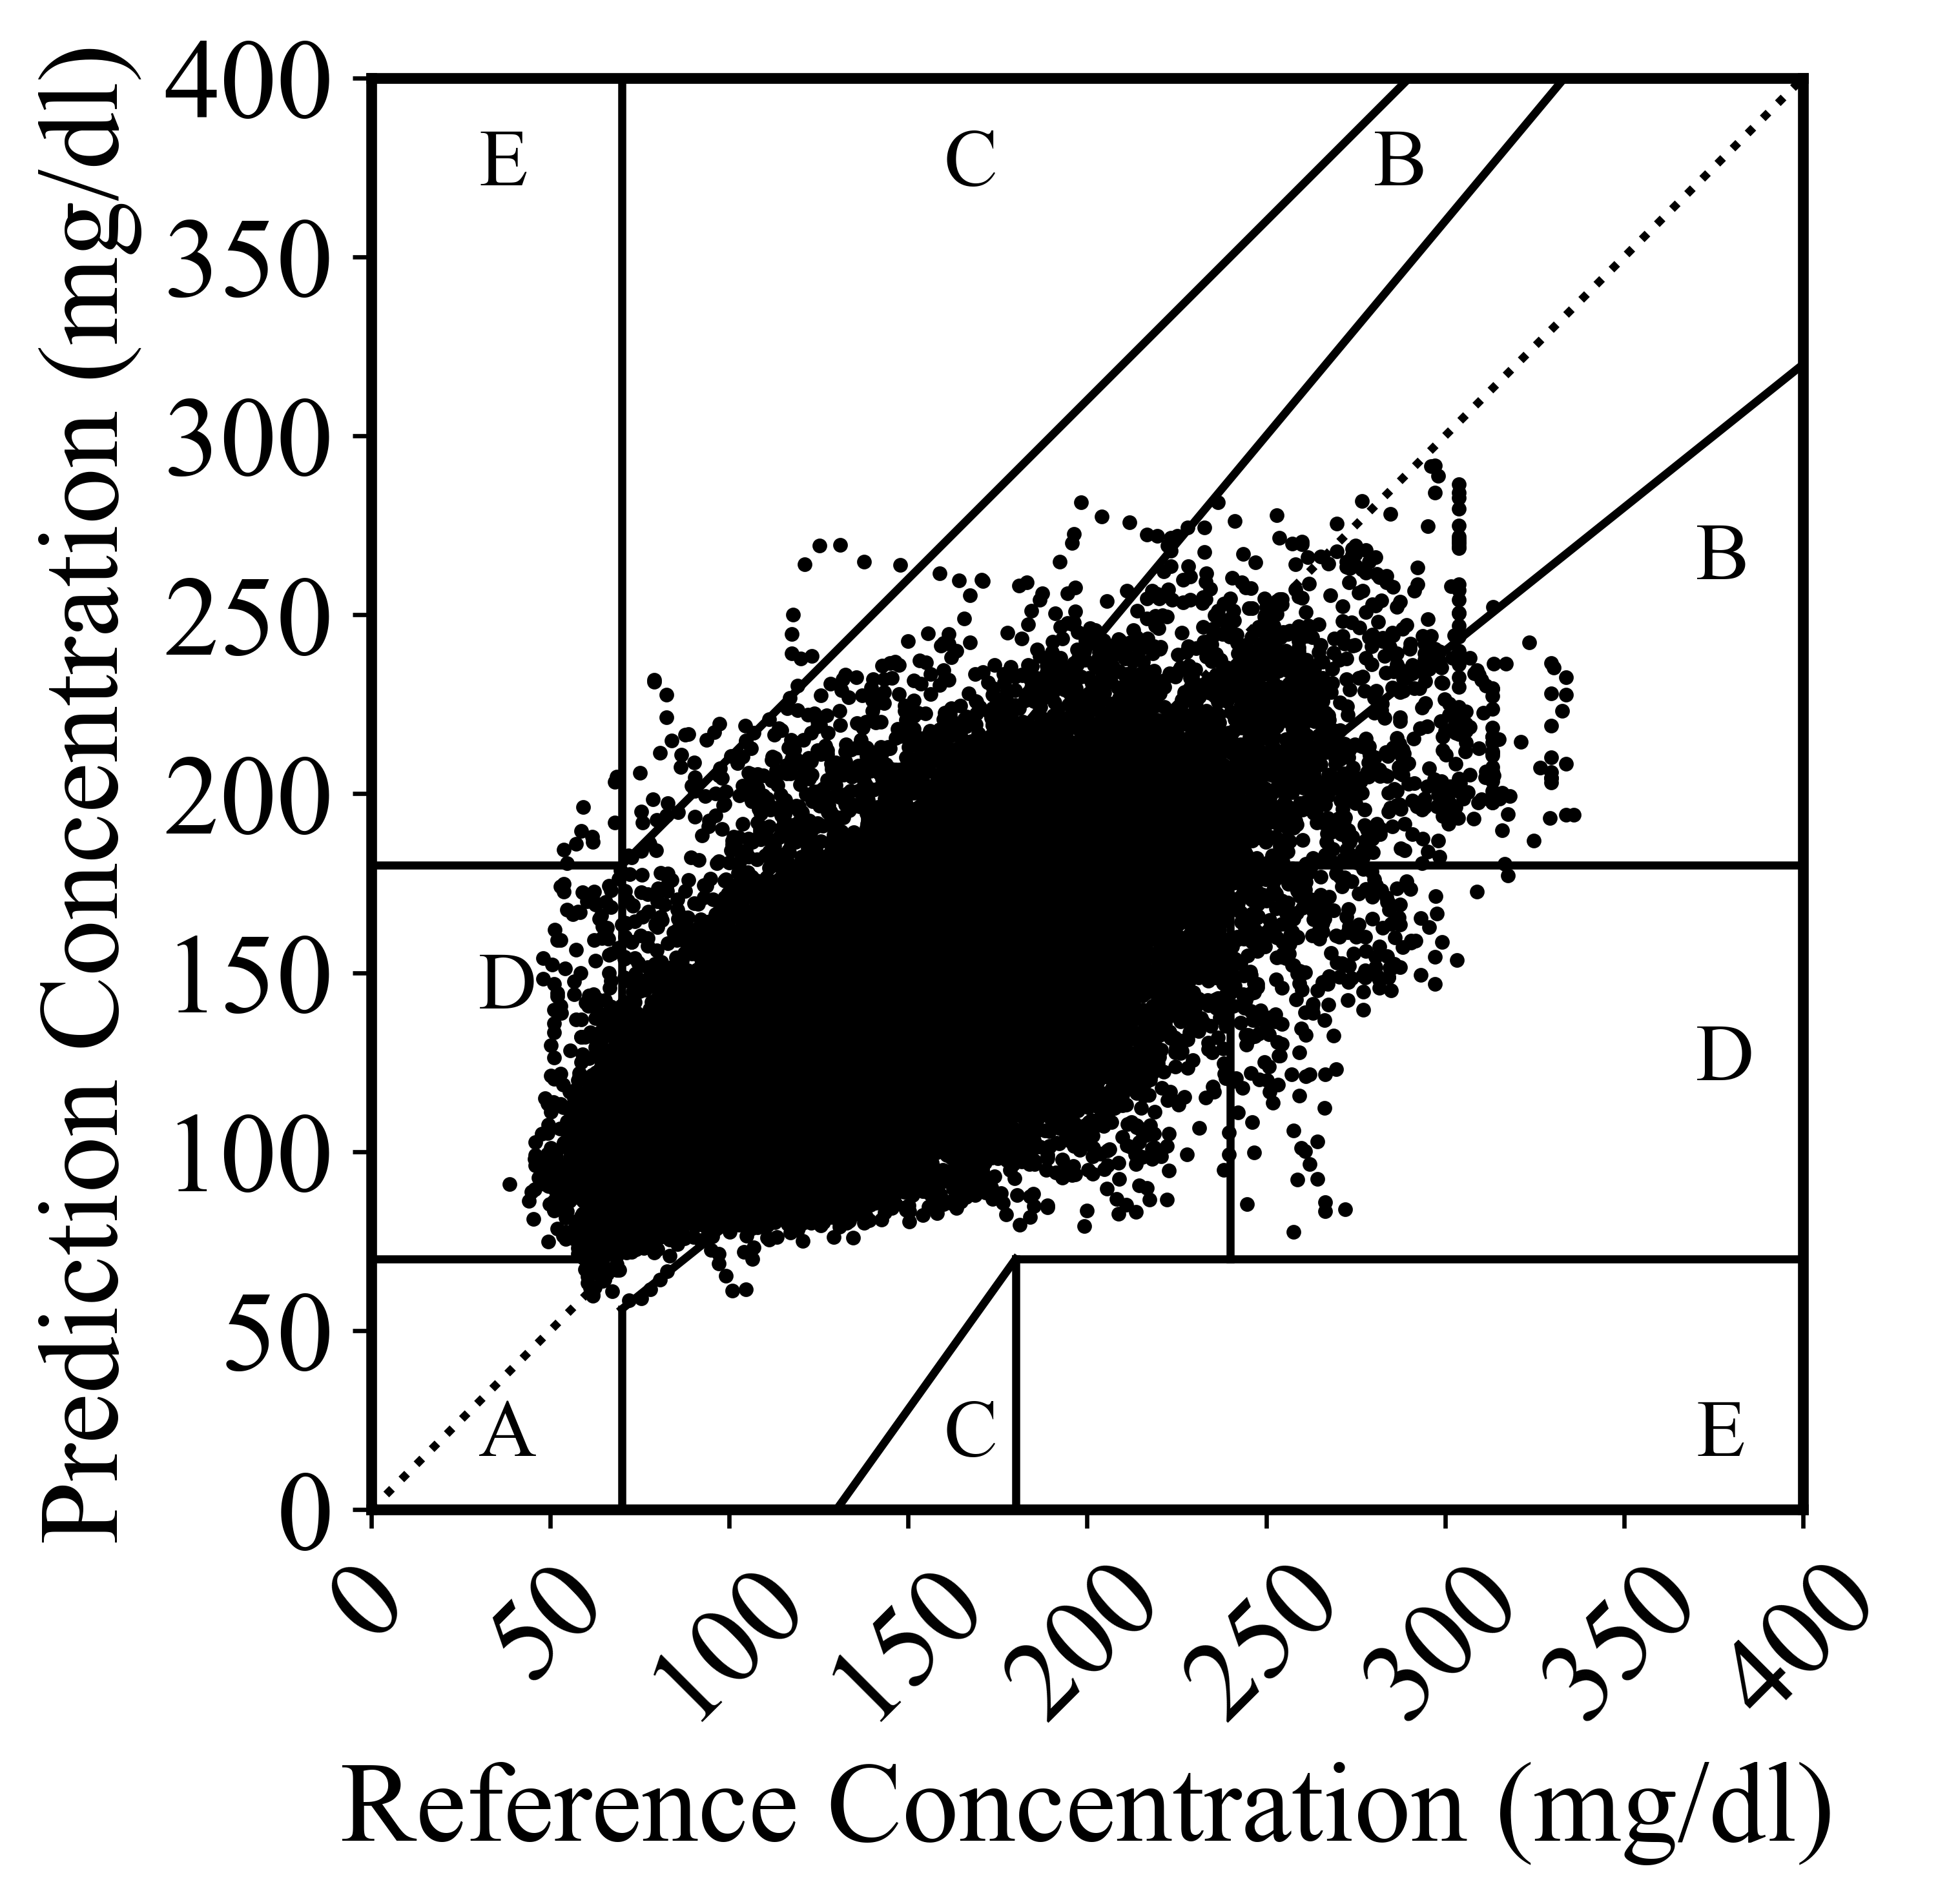

[65.31238378579397, 30.863394074625017, 0.12396181975951406, 3.6692698648816164, 0.030990454939878516]
[21075, 9959, 40, 1184, 10]
prediction horizon: 18
R2 Score: [0.5200903346315299, 0.1598901530850375, 0.6331646500428498, 0.4573462596405744, 0.1805525932701365, 0.3457622530560085, 0.32434853236213, 0.43159920416395225, 0.4367751870555333, 0.18297720054970523, 0.3041105557286984, 0.4088620437529096]
MADP: 18.94%
MADP: 24.77%
MADP: 14.85%
MADP: 19.93%
MADP: 24.43%
MADP: 23.20%
MADP: 23.51%
MADP: 18.54%
MADP: 20.11%
MADP: 22.94%
MADP: 23.55%
MADP: 20.93%


<Figure size 640x480 with 0 Axes>

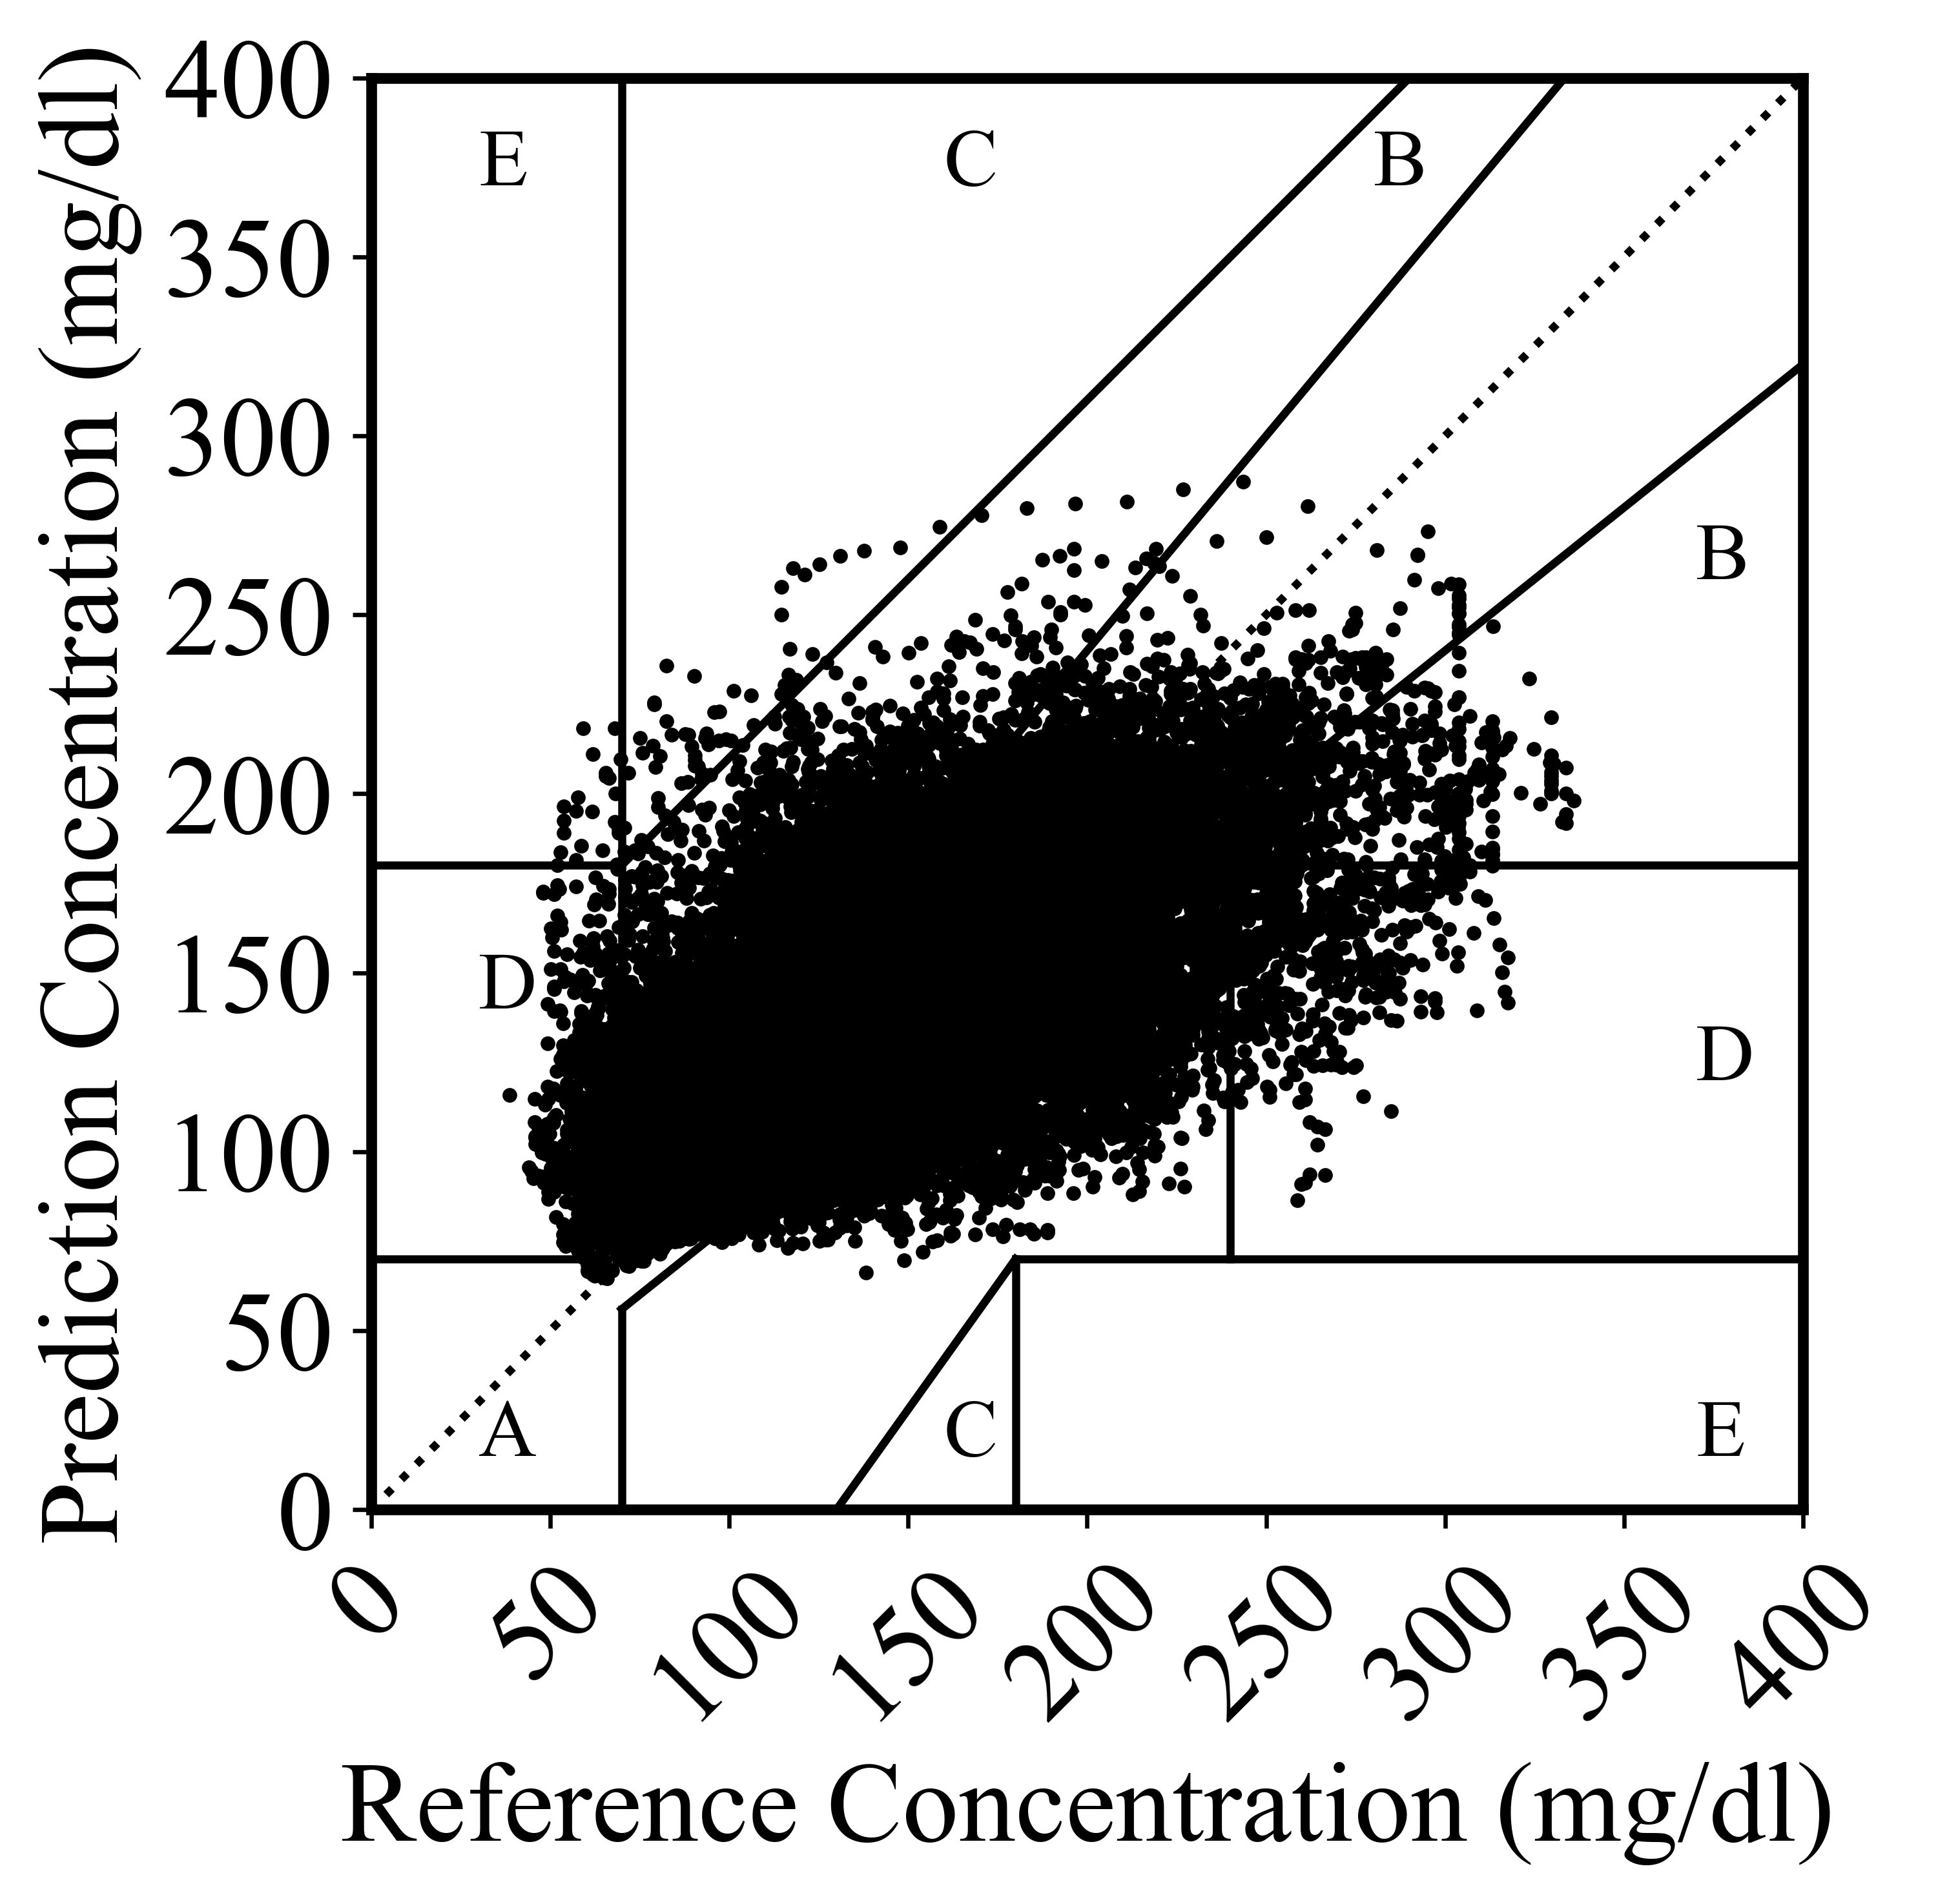

[59.639488706875156, 35.76259617771159, 0.192355423181931, 4.334202035244478, 0.07135765698684537]
[19223, 11527, 62, 1397, 23]
prediction horizon: 24
R2 Score: [0.3923220806377874, -0.20612471928418108, 0.4841364071504316, 0.29836442386895945, 0.030347477736293427, 0.13884825936490275, 0.08704288614101807, 0.23483973646293976, 0.2864840553463427, 0.04077381207891917, 0.11093307314613221, 0.1725668003620321]
MADP: 22.28%
MADP: 31.25%
MADP: 18.46%
MADP: 22.88%
MADP: 27.05%
MADP: 26.67%
MADP: 26.89%
MADP: 23.26%
MADP: 23.21%
MADP: 26.94%
MADP: 25.95%
MADP: 24.86%


<Figure size 640x480 with 0 Axes>

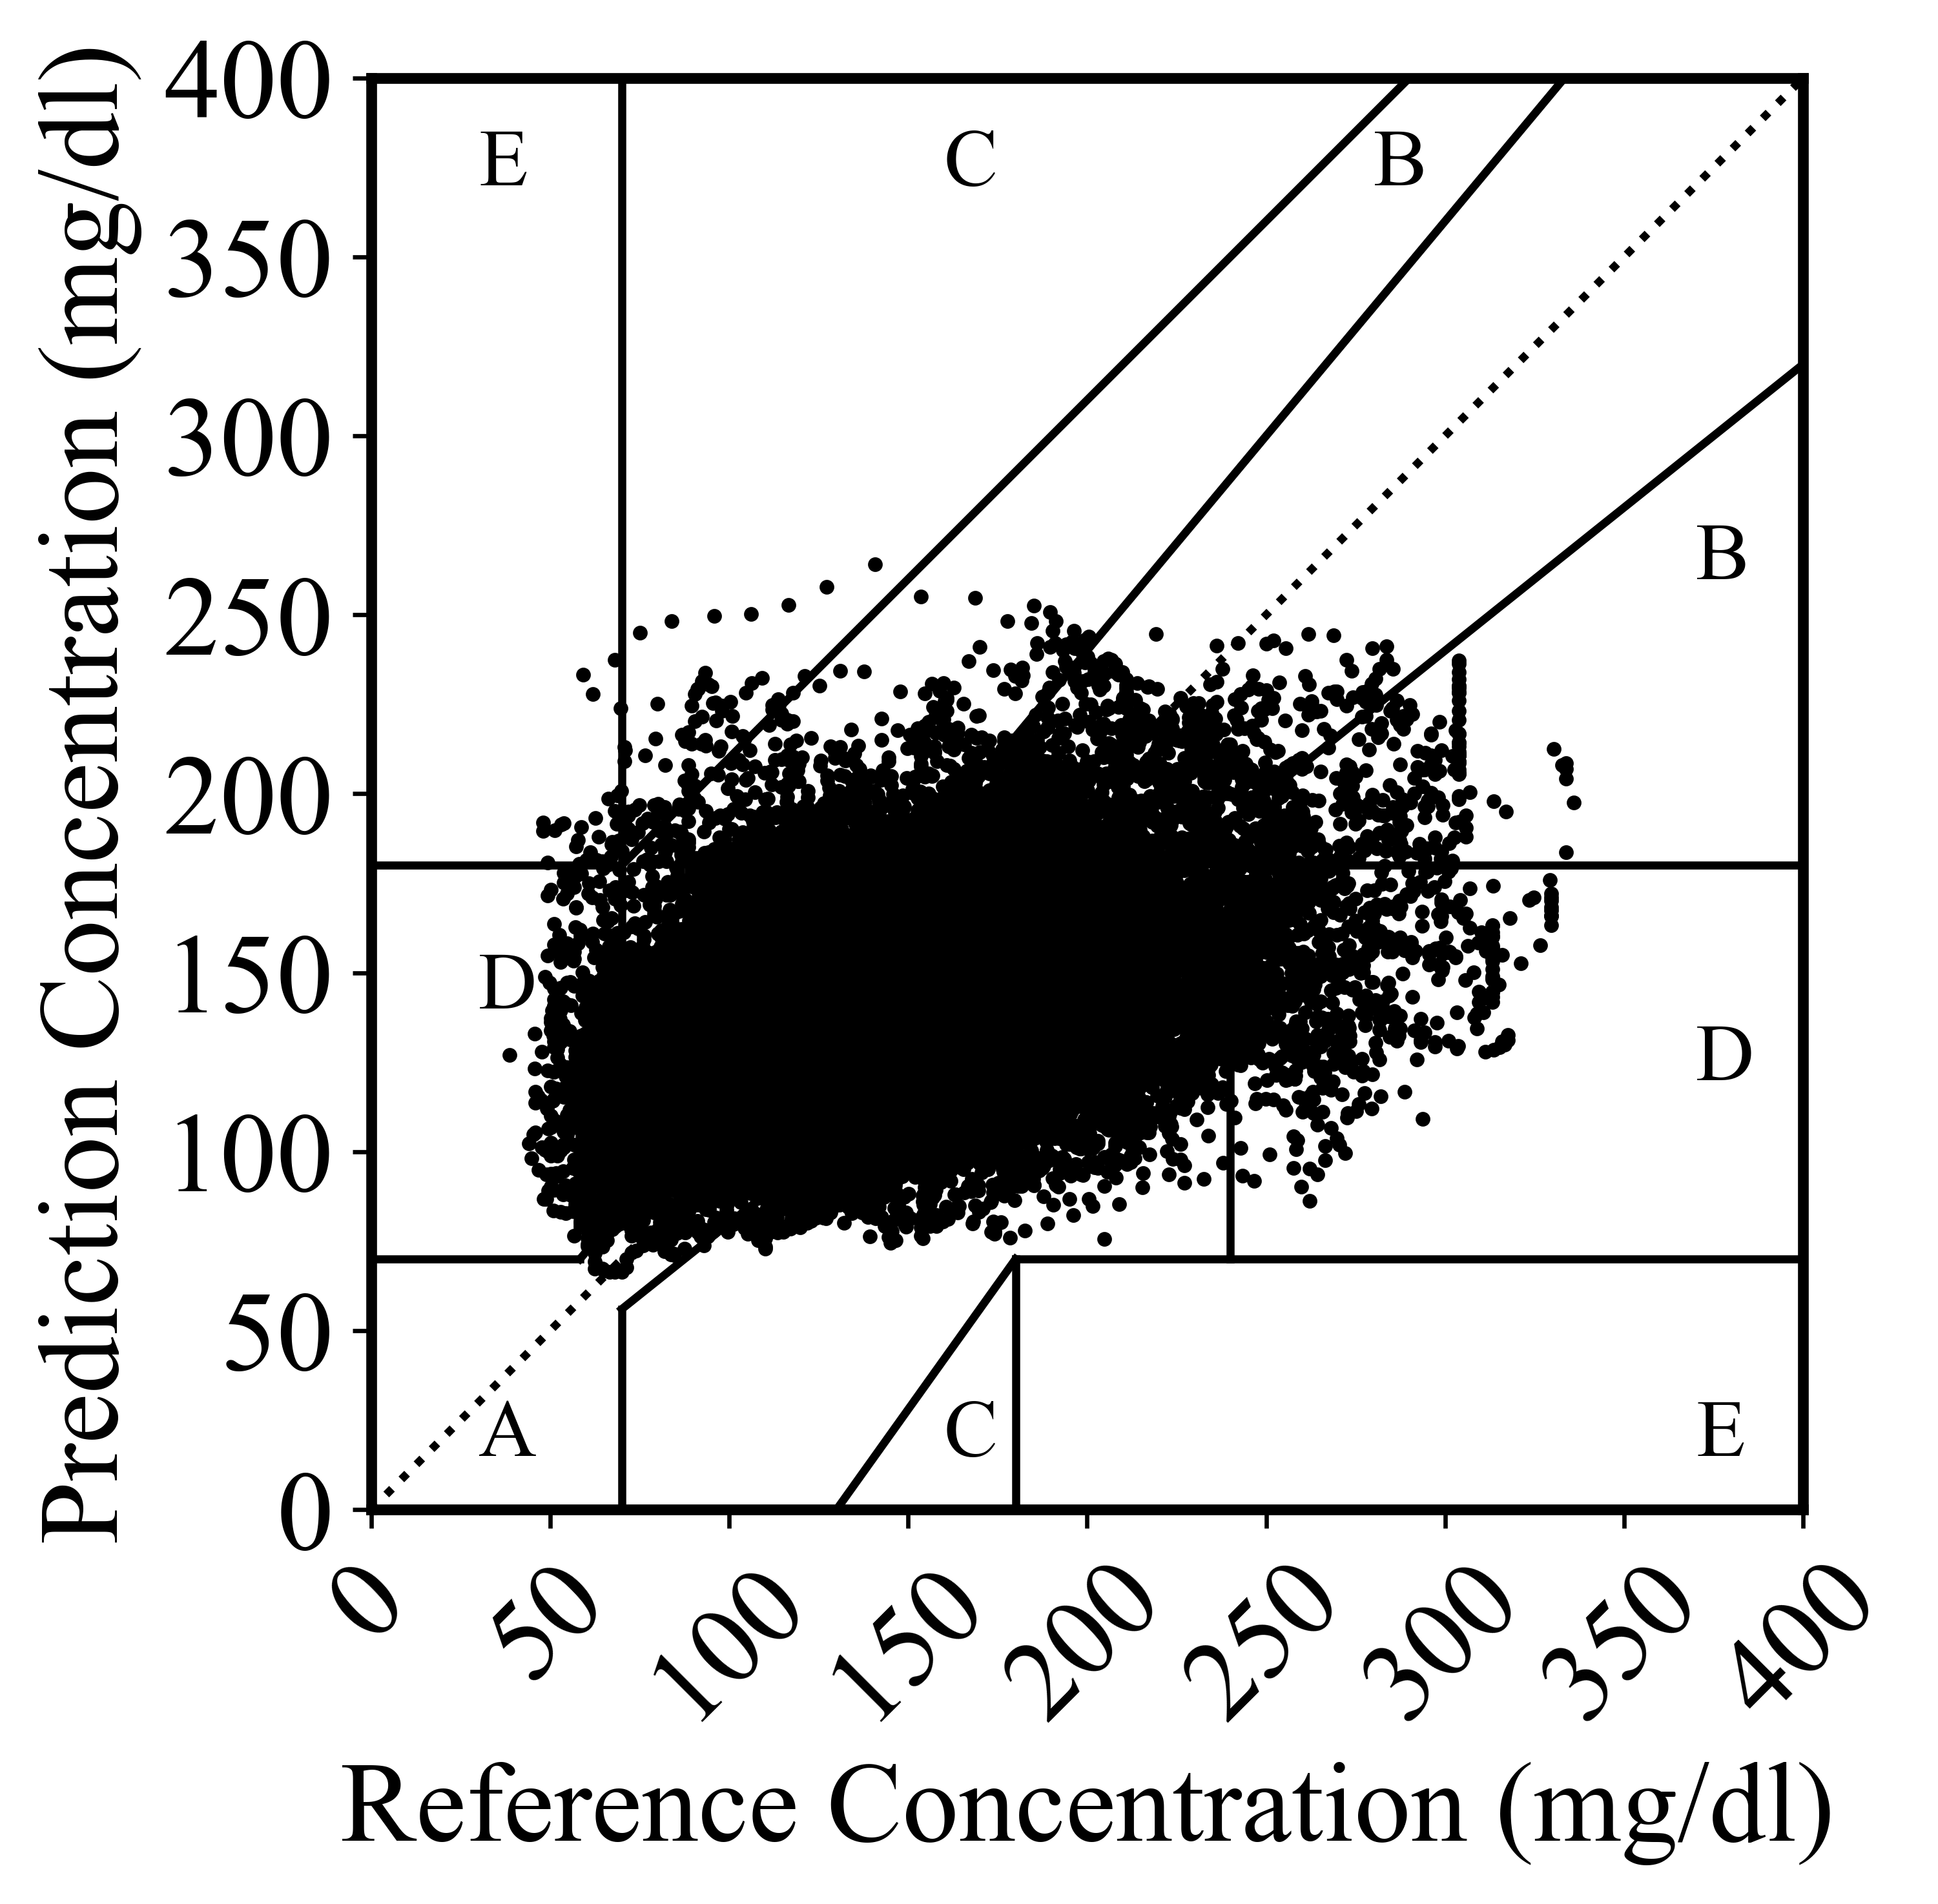

[51.402363184079604, 42.64614427860697, 0.251865671641791, 5.600124378109453, 0.09950248756218905]
[16531, 13715, 81, 1801, 32]


In [9]:
idx = 0
for prediction_horizon in prediction_horizons:
    idx +=1
    print(f"prediction horizon: {prediction_horizon}")    
    model_type = 'shared-layer'
    train_loader, validation_loader, all_train_loader, test_loader, input_shape, input_shape_test, output_shape, output_shape_test =  prepare_data_loader(
                                                                                        window_size,BATCH_SIZE, prediction_horizon,
                                                                                        model_type, split_ratio = 0.7, df = None, df_test = None,
                                                                                        output_folder_train=output_folder_train, shuffle = False)
    model_all_train_read =  SharedLayerModelWithAttention(input_shape =input_shape , output_shape=output_shape)
    predictions_flat_shared_layer, ground_truth_flat_shared_layer = prepare_data_evaluation(scaler, model_type, prediction_horizon, model_all_train_read, test_loader)
    r2_multitasking=r2_score_each_patient(predictions_flat_shared_layer, ground_truth_flat_shared_layer)
    print(f"R2 Score: {r2_multitasking}")    

    MADP_multitasking = MADP_each_patient(predictions_flat_shared_layer, ground_truth_flat_shared_layer)
    for idx, madp in enumerate(MADP_multitasking):
        print(f"MADP: {madp:.2f}%")

    clarke_error_grid(ground_truth_flat_shared_layer.flatten(), predictions_flat_shared_layer.flatten(), "", mask_value)
    